In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tmdbsimple as tmdb
import os
import pickle

In [9]:
with open('../Data/api_key.pkl', 'rb') as hnd:
    tmdb.API_KEY = pickle.load(hnd)['api_key']

In [11]:
search = tmdb.Search()
response = search.movie(query='The Bourne')
for s in search.results:
    print(s['title'], s['id'], s['release_date'], s['popularity'])

The Bourne Legacy 49040 2012-08-08 14.881
The Bourne Identity 2501 2002-06-14 14.088
The Bourne Supremacy 2502 2004-07-23 13.061
The Bourne Ultimatum 2503 2007-08-03 11.41
Bette Bourne: It Goes with the Shoes 179304 2013-03-21 0.847
Jason Bourne 324668 2016-07-27 14.231
Untitled Jeremy Renner/Bourne Sequel 393640  1.393


In [20]:
data = pd.read_csv('../Data/NetflixViewingHistory.csv')

In [21]:
data.shape

(1405, 2)

In [22]:
data.head()

,Title,Date
0,Dating Around: Season 1: Gurki,3/3/19
1,Dating Around: Season 1: Luke,3/3/19
2,The Umbrella Academy: Season 1: We Only See Ea...,2/19/19
3,Trevor Noah: Son of Patricia,11/23/18
4,American Vandal: Season 1: Nailed,11/19/18


In [23]:
data['Date'] = pd.to_datetime(data['Date'])

In [24]:
data1 = data.set_index('Date')

In [26]:
date_gb = data1.groupby(pd.Grouper(freq='W'))

In [28]:
date_gb.count().head()

,Title
Date,
2013-09-15,2
2013-09-22,3
2013-09-29,0
2013-10-06,10
2013-10-13,7


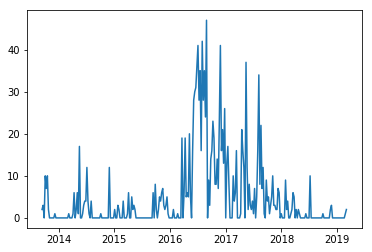

In [30]:
plt.plot(date_gb.count())